<a href="https://colab.research.google.com/github/juliogdomingues/jmr2025/blob/main/JMR2025_CNN_Pr%C3%A1tica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning para classificação de radiografias do tórax

Nesse notebook vamos aprender a realizar pré-processamento de dados, verificar vazamento de dados, treinar um modelo pré-treinado e avaliar com AUC.

Material traduzido e adaptado do curso AI for Medical Diagnosis de DeepLearning.AI (https://www.coursera.org/learn/ai-for-medical-diagnosis) por Júlio Guerra Domingues, Thales Santos e Augusto Antunes.

Baseado no artigo publicado por Rajpurkar P et al. em 2018: https://doi.org/10.1371/journal.pmed.1002686

## About this Dataset
NIH Chest X-ray Dataset
National Institutes of Health Chest X-Ray Dataset
Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. However, clinical diagnosis of a chest X-ray can be challenging and sometimes more difficult than diagnosis via chest CT imaging. The lack of large publicly available datasets with annotations means it is still very difficult, if not impossible, to achieve clinically relevant computer-aided detection and diagnosis (CAD) in real world medical sites with chest X-rays. One major hurdle in creating large X-ray image datasets is the lack resources for labeling so many images. Prior to the release of this dataset, Openi was the largest publicly available source of chest X-ray images with 4,143 images available.

This NIH Chest X-ray Dataset is comprised of 112,120 X-ray images with disease labels from 30,805 unique patients. To create these labels, the authors used Natural Language Processing to text-mine disease classifications from the associated radiological reports. The labels are expected to be >90% accurate and suitable for weakly-supervised learning. The original radiology reports are not publicly available but you can find more details on the labeling process in this Open Access paper: "ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases." (Wang et al.)

Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf



<a name='1'></a>
## 1. Importar Pacotes e Funções

Vamos utilizar os seguintes pacotes:
- `numpy` e `pandas` serão usados para manipular nossos dados
- `matplotlib.pyplot` e `seaborn` serão usados para produzir gráficos para visualização

Também utilizaremos vários módulos do framework `keras` para construir modelos de aprendizado profundo.

Execute a próxima célula para importar todos os pacotes necessários.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model

import os
import math

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

Os próximos blocos fazem o download dos dados

In [2]:
# Instalar o gdown
!pip install gdown

# Baixar o arquivo usando o ID do arquivo
!gdown --id 14j8F2_YhwoQjPc_U-uUTjGYuyGHXpjoZ -O 'nih.zip'


# Descompactar o arquivo
print("Descompactando arquivo. Aguarde...")
!unzip -oq 'nih.zip' -d './'
print("Descompactação concluída.")

# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

df = pd.read_csv("/content/nih/train-small.csv")
IMAGE_DIR = "/content/nih/images-small/"

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=14j8F2_YhwoQjPc_U-uUTjGYuyGHXpjoZ
From (redirected): https://drive.google.com/uc?id=14j8F2_YhwoQjPc_U-uUTjGYuyGHXpjoZ&confirm=t&uuid=e1d6355e-11d3-4bd1-9ef1-eb627cfbc271
To: /content/nih.zip
100% 659M/659M [00:08<00:00, 80.1MB/s]
Descompactando arquivo. Aguarde...
Descompactação concluída.


Funções utilitárias definidas localmente para esta atividade

In [3]:
import random

import cv2
from keras import backend as K
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity
import tensorflow as tf

random.seed(a=None, version=2)

set_verbosity(INFO)


def get_mean_std_per_batch(image_path, df, H=320, W=320):
    sample_data = []
    for idx, img in enumerate(df.sample(100)["Image"].values):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std


def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
    """Load and preprocess image."""
    img_path = image_dir + img
    mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
    x = image.load_img(img_path, target_size=(H, W))
    if preprocess:
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

def grad_cam(input_model, image, cls, layer_name, H=320, W=320):
    """GradCAM method for visualizing input saliency using tf.GradientTape."""
    # Cria um modelo que mapeia a imagem de entrada para as ativações da camada alvo e as predições
    grad_model = tf.keras.models.Model(
        inputs=[input_model.inputs],
        outputs=[input_model.get_layer(layer_name).output, input_model.output]
    )

    with tf.GradientTape() as tape:
        # Assegura que a entrada tenha rastreamento de gradiente
        inputs = tf.cast(image, tf.float32)
        tape.watch(inputs)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, cls]

    # Calcula os gradientes da perda em relação às ativações da camada convolucional
    grads = tape.gradient(loss, conv_outputs)

    # Calcula o peso médio dos gradientes
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Calcula o Grad-CAM
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1).numpy()[0]

    # Processa o CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam_max = cam.max()
    if cam_max != 0:
        cam = cam / cam_max
    return cam

def compute_gradcam(model, img, image_dir, df, labels, selected_labels,
                    layer_name='bn'):
    preprocessed_input = load_image(img, image_dir, df)
    predictions = model.predict(preprocessed_input)

    print("Loading original image")
    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img, image_dir, df, preprocess=False), cmap='gray')

    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print(f"Generating gradcam for class {labels[i]}")
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(f"{labels[i]}: p={predictions[0][i]:.3f}")
            plt.axis('off')
            plt.imshow(load_image(img, image_dir, df, preprocess=False),
                       cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j += 1

def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

<a name='2'></a>
## 2 Carregar os Conjuntos de Dados

Para esta atividade, utilizaremos o [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315), que contém 108.948 imagens de raio-X em vista frontal de 32.717 pacientes únicos.
- Cada imagem no conjunto de dados possui múltiplas etiquetas extraídas de texto, identificando 14 diferentes condições patológicas.
- Essas condições podem ser usadas por médicos para diagnosticar 8 diferentes doenças.
- Usaremos esses dados para desenvolver um modelo único que fornecerá previsões de classificação binária para cada uma das 14 patologias etiquetadas.
- Em outras palavras, ele irá prever 'positivo' ou 'negativo' para cada uma das patologias.

Você pode baixar o conjunto de dados completo gratuitamente [aqui](https://nihcc.app.box.com/v/ChestXray-NIHCC).
- Nós fornecemos um subconjunto de aproximadamente 1000 imagens para você.
- Essas imagens podem ser acessadas no caminho de pasta armazenado na variável `IMAGE_DIR`.

O conjunto de dados inclui um arquivo CSV que fornece as etiquetas para cada raio-X.

Para facilitar o seu trabalho, processamos as etiquetas para nossa amostra reduzida e geramos três novos arquivos para você começar. Esses três arquivos são:

1. `nih/train-small.csv`: 875 imagens do nosso conjunto de dados para uso no treinamento.
2. `nih/valid-small.csv`: 109 imagens do nosso conjunto de dados para uso na validação.
3. `nih/test.csv`: 420 imagens do nosso conjunto de dados para uso no teste.

Este conjunto de dados foi anotado por consenso entre quatro radiologistas diferentes para 5 das nossas 14 patologias:
- `Consolidação`
- `Edema`
- `Efusão`
- `Cardiomegalia`
- `Atelectasia`

#### Observação sobre o significado de 'classe'
Vale destacar que a palavra **'classe'** é usada de várias formas nessas discussões.
- Às vezes, referimos cada uma das 14 condições patológicas etiquetadas em nosso conjunto de dados como uma classe.
- Mas, para cada uma dessas patologias, estamos tentando prever se uma determinada condição está presente (ou seja, resultado positivo) ou ausente (ou seja, resultado negativo).
    - Esses dois rótulos possíveis de 'positivo' ou 'negativo' (ou os equivalentes numéricos de 1 ou 0) também são frequentemente chamados de classes.
- Além disso, também usamos o termo em referência a 'classes' no código de software, como `ImageDataGenerator`.

Contanto que você esteja ciente de tudo isso, não deverá ter confusão, pois o termo 'classe' é geralmente claro pelo contexto em que é utilizado.

#### Lendo os dados
Vamos abrir os arquivos utilizando a biblioteca [pandas](https://pandas.pydata.org/)

In [4]:
train_df = pd.read_csv("/content/nih/train-small.csv")
valid_df = pd.read_csv("/content/nih/valid-small.csv")

test_df = pd.read_csv("/content/nih/test.csv")

IMAGE_DIR = '/content/nih/images-small/'

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


Diretório de imagens: /content/nih/images-small/
Primeiros nomes de arquivos no dataframe:
0    00008270_015.png
1    00029855_001.png
2    00001297_000.png
3    00012359_002.png
4    00017951_001.png
Name: Image, dtype: object
Arquivos no diretório de imagens:
['00016732_001.png', '00005962_001.png', '00012884_002.png', '00016657_000.png', '00000549_000.png', '00000875_000.png', '00015090_005.png', '00012874_032.png', '00013648_008.png', '00028846_003.png', '00028518_024.png', '00010390_004.png', '00020770_000.png', '00017417_004.png', '00006332_008.png', '00005231_002.png', '00010012_006.png', '00013049_004.png', '00010932_006.png', '00010651_000.png', '00021489_003.png', '00011971_007.png', '00028357_030.png', '00021706_004.png', '00012045_053.png', '00013774_053.png', '00015387_000.png', '00019333_002.png', '00021035_010.png', '00020552_000.png', '00008081_005.png', '00001872_012.png', '00012594_002.png', '00018840_043.png', '00029464_012.png', '00007816_010.png', '00021902_000.png

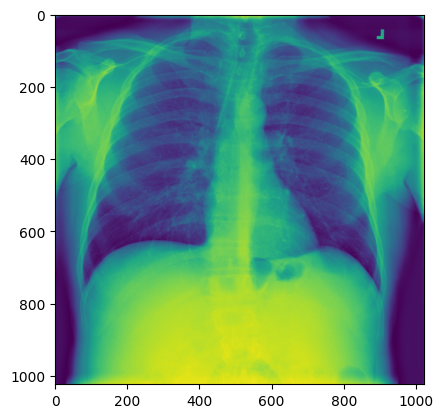

In [5]:
labels = ['Cardiomegaly',
          'Emphysema',
          'Effusion',
          'Hernia',
          'Infiltration',
          'Mass',
          'Nodule',
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening',
          'Pneumonia',
          'Fibrosis',
          'Edema',
          'Consolidation']

# Verificando o caminho e os primeiros valores dos arquivos de imagem
print("Diretório de imagens:", IMAGE_DIR)
print("Primeiros nomes de arquivos no dataframe:")
print(train_df["Image"].head())

# Exibe os arquivos no diretório para verificar a extensão
print("Arquivos no diretório de imagens:")
print(os.listdir(IMAGE_DIR))

# Exibe um imagem
img_path = os.path.join(IMAGE_DIR, train_df["Image"].iloc[0])
img = mpimg.imread(img_path)
plt.imshow(img)
plt.show()

### Preparação dos Dados para o Modelo

Nessa etapa, preparamos os dados para o modelo utilizando o `ImageDataGenerator` do Keras, o que permite a criação de geradores de dados para os conjuntos de treinamento, validação e teste. Primeiro, implementamos uma função para verificar a presença de vazamento de dados entre os conjuntos (caso o mesmo paciente apareça em diferentes conjuntos). Em seguida, configuramos o gerador para o conjunto de treino, aplicando centralização e padronização por lote, além de espelhamento horizontal aleatório para aumentar o conjunto de dados. Para os conjuntos de validação e teste, aplicamos a normalização com base nas estatísticas do conjunto de treino, garantindo que o modelo não receba informações indesejadas dos dados de teste.

Para concluir, inicializamos um gerador de treino e geradores de validação e teste para que o modelo possa consumir os dados com consistência.

Obtendo gerador de treino...
Found 1000 validated image filenames.
Obtendo geradores de validação e teste...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


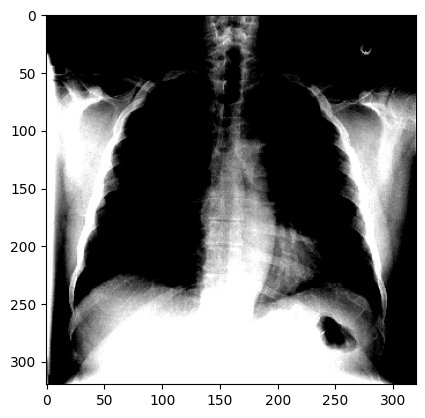

In [6]:
# Função para verificar vazamento de dados
def check_for_leakage(df1, df2, patient_col):
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)
    leakage = len(patients_in_both_groups) > 0
    return leakage

# Função para gerar dados de treino com normalização por lote
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w=320, target_h=320):
    print("Obtendo gerador de treino...")
    image_generator = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
    generator = image_generator.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        target_size=(target_w, target_h))
    return generator

# Função para gerar dados de validação e teste com normalização baseada em treino
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w=320, target_h=320):
    print("Obtendo geradores de validação e teste...")
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))

    data_sample = raw_train_generator.__getitem__(0)[0]
    # data_sample = raw_train_generator.next()[0]
    image_generator = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    image_generator.fit(data_sample)

    valid_generator = image_generator.flow_from_dataframe(
        dataframe=valid_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w, target_h))
    test_generator = image_generator.flow_from_dataframe(
        dataframe=test_df,
        directory=image_dir,
        x_col=x_col,
        y_col=y_cols,
        class_mode="raw",
        batch_size=batch_size,
        shuffle=False,
        seed=seed,
        target_size=(target_w, target_h))
    return valid_generator, test_generator

# Configuração dos diretórios e inicialização dos geradores
IMAGE_DIR = "/content/nih/images-small/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator = get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

# Exemplo de visualização do gerador
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])
plt.show()

<a name='3'></a>
## 3 Desenvolvimento do Modelo

Agora vamos avançar para o treinamento e desenvolvimento do modelo. Temos alguns desafios práticos a enfrentar antes de treinar uma rede neural. O primeiro deles é o desequilíbrio entre as classes.

<a name='3-1'></a>
### 3.1 Lidando com o Desequilíbrio entre Classes
Um dos desafios ao trabalhar com conjuntos de dados de diagnóstico médico é o grande desequilíbrio entre classes presente nesses conjuntos. Vamos plotar a frequência de cada um dos rótulos em nosso conjunto de dados:

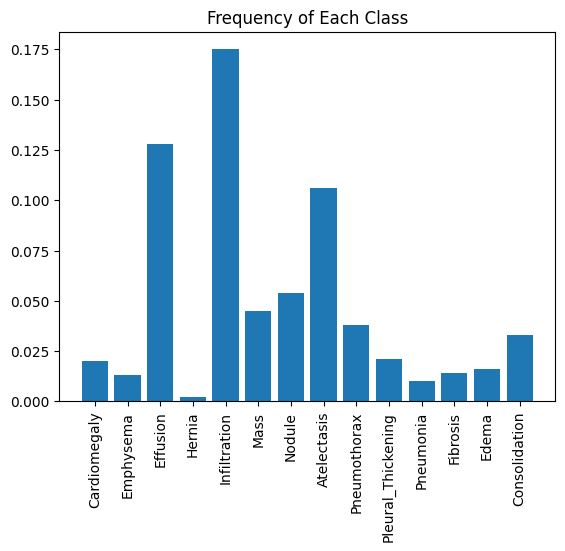

In [7]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

Podemos ver nesse gráfico que a prevalência de casos positivos varia significativamente entre as diferentes doenças. (Essas tendências refletem também o conjunto de dados completo.)
* A patologia `Hérnia` apresenta o maior desequilíbrio, com uma proporção de casos positivos no treinamento de cerca de 0,2%.
* Já a patologia `Infiltração`, com o menor grau de desequilíbrio, possui apenas 17,5% dos casos de treinamento rotulados como positivos.

Idealmente, deveríamos treinar nosso modelo com um conjunto de dados equilibrado, onde os casos de treinamento positivos e negativos contribuiriam igualmente para a função de perda.

Se utilizarmos uma função de perda de entropia cruzada com um conjunto de dados altamente desequilibrado, como observamos aqui, o algoritmo tende a priorizar a classe majoritária (neste caso, a classe negativa), já que ela contribui mais para a perda.

#### Impacto do desequilíbrio entre classes na função de perda

Vamos examinar isso mais de perto. Suponha que utilizamos uma função de perda de entropia cruzada para cada patologia. Lembramos que a contribuição da entropia cruzada para a perda no caso de dados de treinamento $i$ é:

$$\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i))),$$

onde $x_i$ e $y_i$ são as características de entrada e o rótulo, e $f(x_i)$ é a saída do modelo, ou seja, a probabilidade de ser positivo.

Observe que para qualquer caso de treinamento, ou $y_i=0$ ou $(1-y_i)=0$, então apenas um desses termos contribui para a perda (o outro termo é multiplicado por zero e torna-se zero).

Podemos reescrever a perda média de entropia cruzada para todo o conjunto de treinamento $\mathcal{D}$ de tamanho $N$ da seguinte forma:

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{exemplos positivos}} \log (f(x_i)) + \sum_{\text{exemplos negativos}} \log(1-f(x_i)) \big).$$

Usando essa formulação, podemos ver que, se houver um grande desequilíbrio com muito poucos casos positivos, por exemplo, a perda será dominada pela classe negativa. Somando a contribuição em todos os casos de treinamento para cada classe (isto é, condição patológica), vemos que a contribuição de cada classe (ou seja, positiva ou negativa) é:

$$freq_{p} = \frac{\text{número de exemplos positivos}}{N} $$

$$\text{e}$$

$$freq_{n} = \frac{\text{número de exemplos negativos}}{N}.$$

<a name='Ex-2'></a>
### Cálculo das Frequências das Classes
Calcular essas frequências para cada rótulo em nosso conjunto de dados.

In [8]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """

    # total number of patients (rows).
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = np.sum(labels==0, axis=0) / N


    return positive_frequencies, negative_frequencies


# Test
labels_matrix = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
print("labels:")
print(labels_matrix)

test_pos_freqs, test_neg_freqs = compute_class_freqs(labels_matrix)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]


#### Saída esperada

```Python
labels:
[[1 0 0]
 [0 1 1]
 [1 0 1]
 [1 1 1]
 [1 0 1]]
pos freqs: [0.8 0.4 0.8]
neg freqs: [0.2 0.6 0.2]
```

Agora, vamos calcular as frequências para nossos dados de treinamento.

Vamos visualizar essas duas razões de contribuição lado a lado para cada uma das patologias:

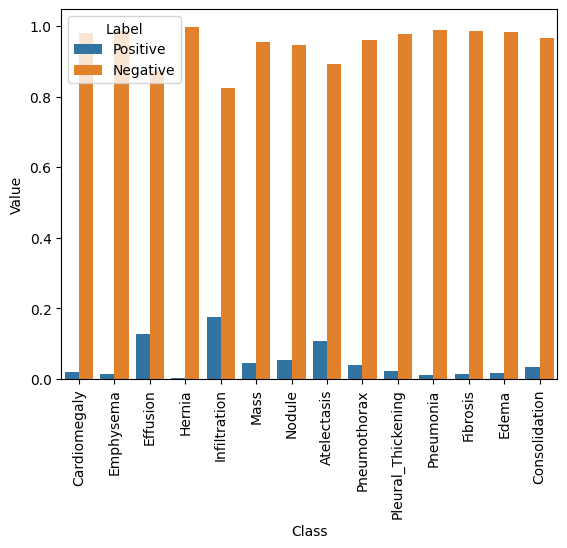

In [9]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data2 = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])
data = pd.concat([data, data2], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()

Como vemos no gráfico acima, as contribuições dos casos positivos são significativamente menores do que as dos casos negativos. No entanto, queremos que as contribuições sejam iguais. Uma maneira de fazer isso é multiplicando cada exemplo de cada classe por um fator de peso específico para a classe, $w_{pos}$ e $w_{neg}$, de forma que a contribuição geral de cada classe seja a mesma.

Para isso, queremos que

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

o que podemos fazer simplesmente tomando

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

Dessa forma, estaremos equilibrando a contribuição dos rótulos positivos e negativos.

Vamos verificar isso graficando novamente as duas contribuições lado a lado:

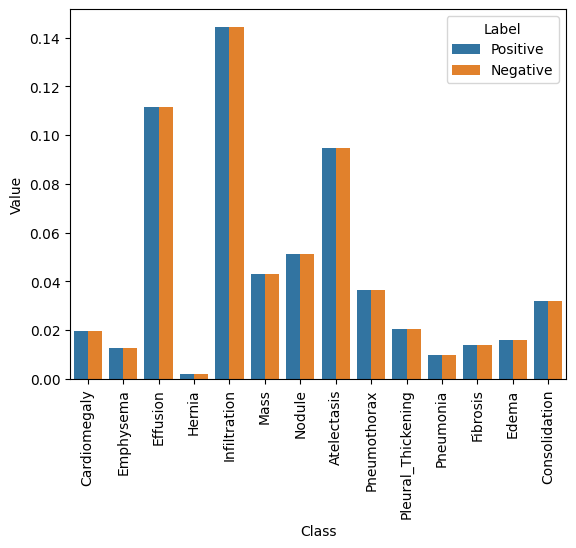

In [10]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights
neg_contribution = freq_neg * neg_weights


data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data2 = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v}
                        for l,v in enumerate(neg_contribution)])
data = pd.concat([data, data2], ignore_index=True) # Concatenate data and data2

plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);
plt.show()

Como mostra a figura acima, ao aplicar esses pesos, os rótulos positivos e negativos dentro de cada classe terão a mesma contribuição agregada para a função de perda. Agora, vamos implementar uma função de perda com essa ponderação.

Após calcular os pesos, nossa perda final ponderada para cada caso de treinamento será:

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

<a name='Ex-3'></a>
### Perda Ponderada
A função `weighted_loss` retorna uma função que calcula a perda ponderada para cada lote. Lembre-se de que, para a perda de múltiplas classes, somamos a perda média para cada classe individual. Note também que adicionamos um pequeno valor, $\epsilon$, aos valores previstos antes de calcular o log. Isso evita um erro numérico que ocorreria caso o valor previsto fosse zero.

##### Nota
Funções do Keras para calcular a média e o log:

- [Keras.mean](https://www.tensorflow.org/api_docs/python/tf/keras/backend/mean)
- [Keras.log](https://www.tensorflow.org/api_docs/python/tf/keras/backend/log)

Agora vamos testar nossa função com alguns casos simples.

In [11]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)

    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value.

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Tensor): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss += -1 * K.mean((pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon) +
                     neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon)))
        return loss

    return weighted_loss

from tensorflow.keras import backend as K

print("Test example:\n")
y_true = K.constant(np.array(
    [[1, 1, 1],
     [1, 1, 0],
     [0, 1, 0],
     [1, 0, 1]]
))
print("y_true:\n")
print(y_true.numpy())

w_p = np.array([0.25, 0.25, 0.5])
w_n = np.array([0.75, 0.75, 0.5])
print("\nw_p:\n")
print(w_p)

print("\nw_n:\n")
print(w_n)

y_pred_1 = K.constant(0.7*np.ones(y_true.shape))
print("\ny_pred_1:\n")
print(y_pred_1.numpy())

y_pred_2 = K.constant(0.3*np.ones(y_true.shape))
print("\ny_pred_2:\n")
print(y_pred_2.numpy())

# test with a large epsilon in order to catch errors
L = get_weighted_loss(w_p, w_n, epsilon=1)

print("\nIf we weighted them correctly, we expect the two losses to be the same.")
L1 = L(y_true, y_pred_1).numpy() # Use .numpy()
L2 = L(y_true, y_pred_2).numpy() # Use .numpy()
print(f"\nL(y_pred_1)= {L1:.4f}, L(y_pred_2)= {L2:.4f}")
print(f"Difference is L1 - L2 = {L1 - L2:.4f}")

Test example:

y_true:

[[1. 1. 1.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 1.]]

w_p:

[0.25 0.25 0.5 ]

w_n:

[0.75 0.75 0.5 ]

y_pred_1:

[[0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]
 [0.7 0.7 0.7]]

y_pred_2:

[[0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]
 [0.3 0.3 0.3]]

If we weighted them correctly, we expect the two losses to be the same.

L(y_pred_1)= -0.4956, L(y_pred_2)= -0.4956
Difference is L1 - L2 = 0.0000


<a name='3-3'></a>
### 3.3 DenseNet121

Em seguida, utilizaremos um modelo pré-treinado [DenseNet121](https://www.kaggle.com/pytorch/densenet121), que podemos carregar diretamente do Keras e então adicionar duas camadas sobre ele:
1. Uma camada `GlobalAveragePooling2D` para obter a média das últimas camadas convolucionais do DenseNet121.
2. Uma camada `Dense` com ativação `sigmoid` para obter os logits de predição para cada uma das nossas classes.

Podemos definir nossa função de perda personalizada para o modelo especificando o parâmetro `loss` na função `compile()`.

In [12]:
# create the base pre-trained model
base_model = DenseNet121(weights='/content/nih/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, None,      │          0 │ conv2_block1_0_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, None,      │          0 │ pool1[0][0],      │
│ (Concatenate)       │ None, 96)         │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, None,      │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, None,      │          0 │ conv2_block2_0_b… │
│ (Activation)        │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, None,      │     12,288 │ conv2_block2_0_r

 Total params: 7,051,854 (26.90 MB)

 Trainable params: 6,968,206 (26.58 MB)

 Non-trainable params: 83,648 (326.75 KB)

## 4 Treinamento do modelo

Com nosso modelo pronto para o treinamento, usaremos a função `model.fit()` do Keras para treinar o modelo. Como o treinamento pode demorar consideravelmente, optamos por não treinar o modelo aqui, mas sim carregar um conjunto de pesos pré-treinados.

Os prints abaixo mostram como se dá o processo de treinamento de um modelo (outro modelo, no caso)

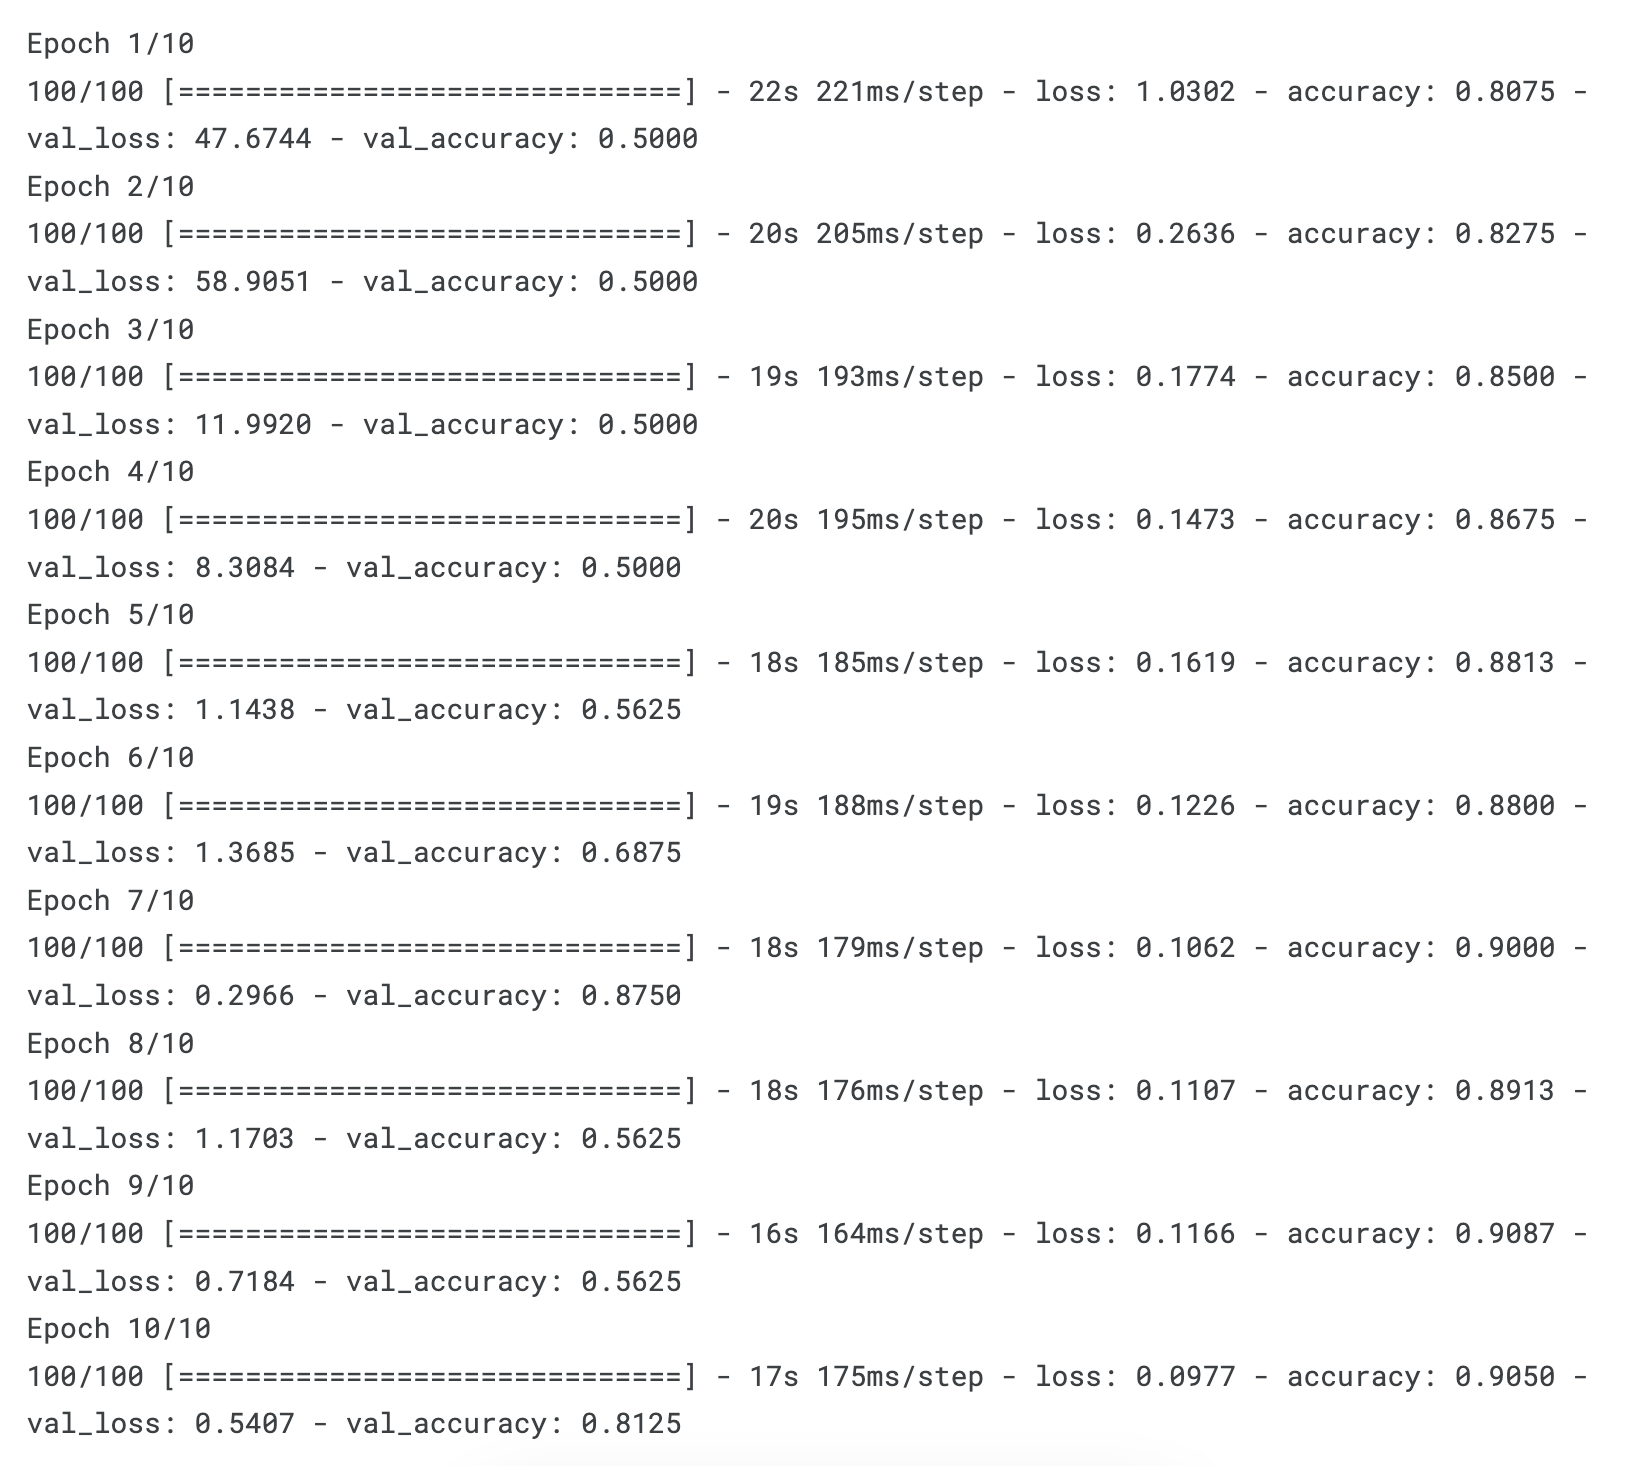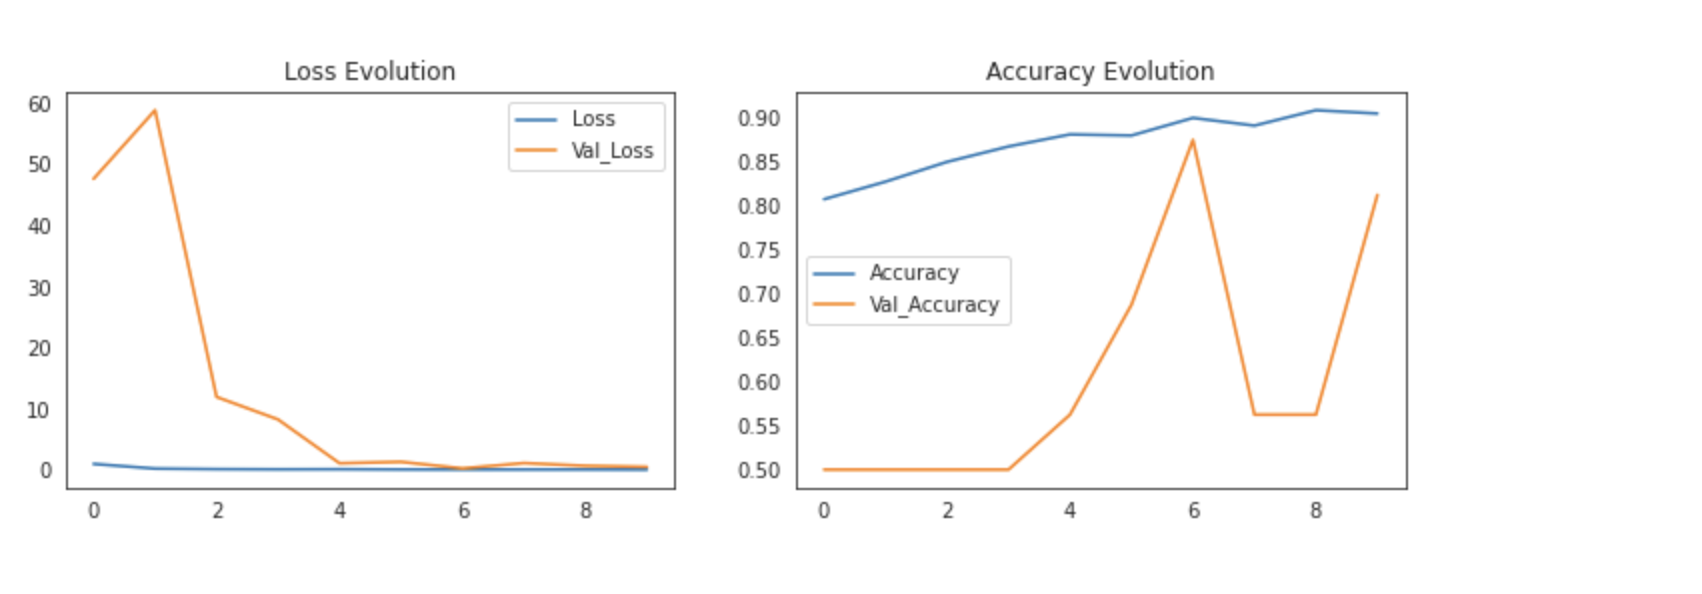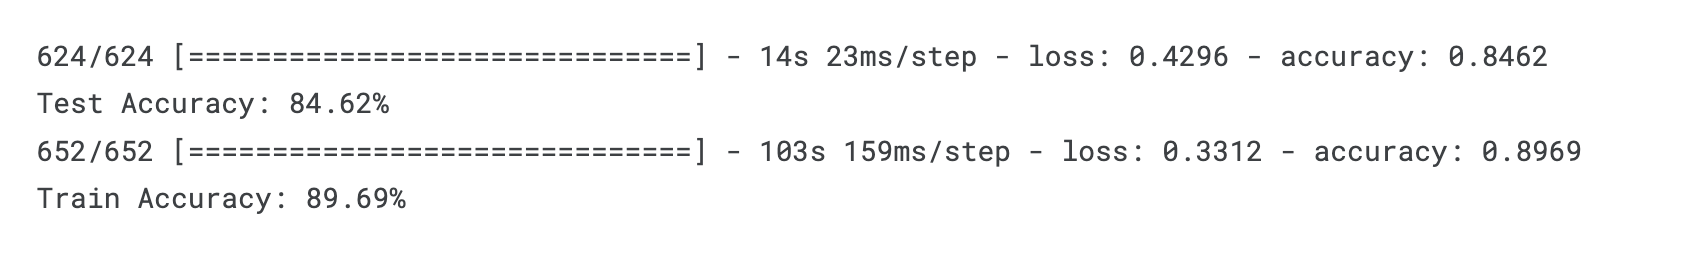

Na última seção do notebook, temos um código para treinar o modelo em um parcela pequena dos dados.
- Estamos treinando em um pequeno subconjunto do conjunto de dados (~1%).
- Nosso objetivo, neste ponto, é garantir que a perda no conjunto de treinamento esteja diminuindo.

<a name='4-1'></a>
### 4.1 Treinando no Conjunto de Dados Completo

Considerando que o conjunto de dados original tem mais de 40GB e o processo de treinamento completo leva algumas horas, treinamos o modelo em uma máquina com GPU para você e fornecemos o arquivo de pesos do modelo (com um tamanho de lote de 32) para ser utilizado no restante deste exercício.

A arquitetura do modelo pré-treinado é exatamente a mesma, mas usamos alguns "callbacks" úteis do Keras durante o treinamento. Dedique algum tempo para ler sobre esses callbacks quando puder, pois eles são muito úteis para gerenciar sessões de treinamento longas:

1. Você pode usar o callback `ModelCheckpoint` para monitorar a métrica `val_loss` do modelo e salvar um snapshot do modelo nesse ponto.
2. O `TensorBoard` permite utilizar a ferramenta TensorBoard do TensorFlow para monitorar suas execuções em tempo real.
3. Com o `ReduceLROnPlateau`, você pode reduzir lentamente a taxa de aprendizado do modelo quando ele para de melhorar em uma métrica como `val_loss`, afinando o modelo nas etapas finais do treinamento.
4. O callback `EarlyStopping` permite parar o treinamento quando o modelo não mostra mais melhora na perda de validação (`val_loss`). É possível definir um valor de `patience`, ou paciência, que representa o número de épocas sem melhora após o qual o treinamento é interrompido. Este callback também pode restaurar os pesos correspondentes ao melhor valor da métrica ao final do treinamento.

Você pode ler sobre esses callbacks e outros úteis do Keras [aqui](https://keras.io/callbacks/).

Vamos agora carregar os pesos pré-treinados em nosso modelo:

In [13]:
model.load_weights("/content/nih/pretrained_model.h5")

<a name='5'></a>
## 5 Predição e Avaliação

Agora que temos um modelo, vamos avaliá-lo usando nosso conjunto de teste. Podemos usar convenientemente a função `predict_generator` para gerar as predições para as imagens em nosso conjunto de teste.

**Nota:** A célula a seguir pode levar alguns minutos para ser executada.

In [14]:
predicted_vals = model.predict(test_generator, steps = len(test_generator))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 38s 398ms/step


<a name='5-1'></a>
### 5.1 Curva ROC e AUROC
Vamos calcular uma métrica chamada AUC (Área Sob a Curva) da curva ROC ([Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)). Esta métrica também é chamada de AUROC, e você verá esses três termos usados quase de forma intercambiável.

Para interpretar o gráfico é que uma curva mais à esquerda e próxima do topo possui mais "área" abaixo dela, o que indica que o modelo está com melhor desempenho.

Usaremos a função `get_roc_curve()`. Analise essa função e observe o uso das funções da biblioteca `sklearn` para gerar as curvas ROC e os valores de AUROC para o nosso modelo.

- [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

/tmp/ipython-input-3-3623171074.py:104: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
/tmp/ipython-input-3-3623171074.py:104: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
/tmp/ipython-input-3-3623171074.py:104: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
/tmp/ipython-input-3-3623171074.py:104: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
/tmp/ipython-input-3-3623171074.py:104: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1, figsize=(10, 10))
/tmp/ipython-input-3-3623171074.py:104: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.fi

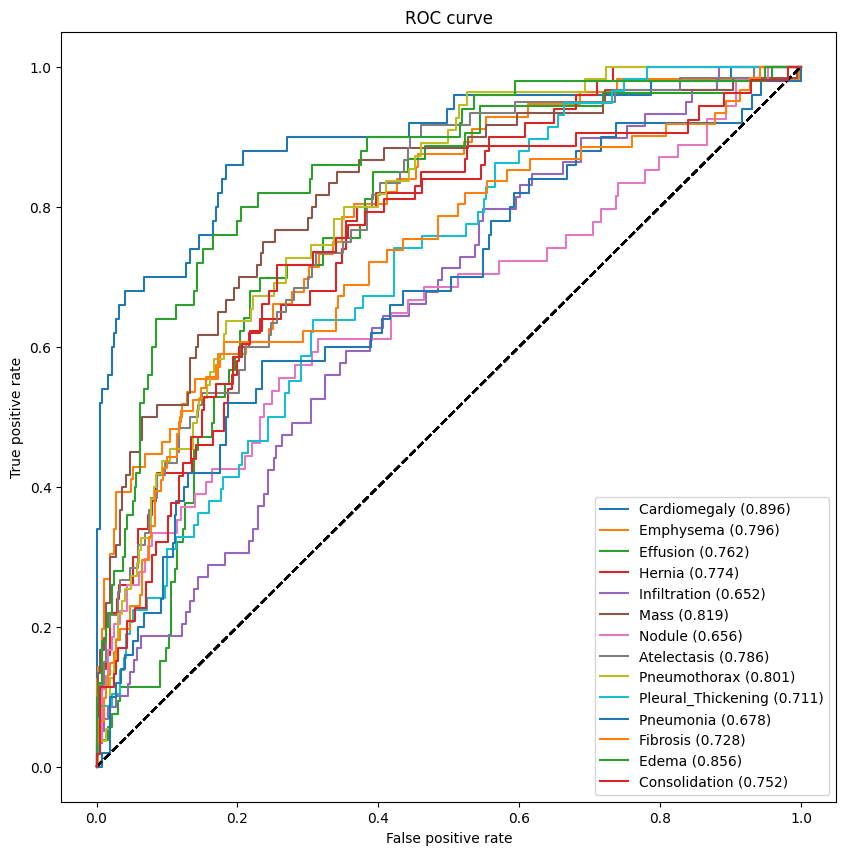

In [15]:
auc_rocs = get_roc_curve(labels, predicted_vals, test_generator)

Você pode comparar o desempenho com os valores de AUC relatados no artigo original do ChexNeXt na tabela abaixo:

Para referência, aqui está a figura de AUC do artigo ChexNeXt, que inclui os valores de AUC para o modelo deles, assim como os valores para radiologistas neste conjunto de dados:

<img src="https://journals.plos.org/plosmedicine/article/figure/image?size=large&id=10.1371/journal.pmed.1002686.t001" width="80%">

Esse método também utiliza algumas outras técnicas, como autoaprendizagem e ensembling, que podem dar um aumento significativo no desempenho.

<a name='5-2'></a>
### 5.2 Visualizando o Aprendizado com GradCAM

Um dos desafios de usar aprendizado profundo na medicina é que a arquitetura complexa usada para redes neurais as torna muito mais difíceis de interpretar em comparação com modelos tradicionais de aprendizado de máquina (por exemplo, modelos lineares).

Uma das abordagens mais comuns para aumentar a interpretabilidade de modelos em tarefas de visão computacional é o uso de Mapas de Ativação de Classe (CAM).
- Mapas de ativação de classe são úteis para entender onde o modelo está "focando" ao classificar uma imagem.

Nesta seção, usaremos a técnica de [GradCAM](https://arxiv.org/abs/1610.02391) para produzir um mapa de calor destacando as regiões importantes da imagem para a predição da condição patológica.
- Isso é feito extraindo os gradientes de cada classe prevista, fluindo para a camada final de convolução do nosso modelo. Veja a função `compute_gradcam` para entender como isso é feito com o framework Keras.

Vale mencionar que o GradCAM não fornece uma explicação completa do raciocínio para cada probabilidade de classificação.
- No entanto, ainda é uma ferramenta útil para "depurar" nosso modelo e complementar nossa predição, permitindo que um especialista valide se uma predição é realmente baseada no foco do modelo nas regiões corretas da imagem.

Primeiro, vamos carregar o pequeno conjunto de treinamento e configurar para visualizar as 4 classes com as maiores medidas de AUC.

In [16]:
df = pd.read_csv("/content/nih/train-small.csv")
IMAGE_DIR = "/content/nih/images-small/"

# only show the lables with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

Agora, vamos observar algumas imagens específicas.

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Loading original image
Generating gradcam for class Cardiomegaly


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 320, 320, 3))
  warnings.warn(msg)


Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


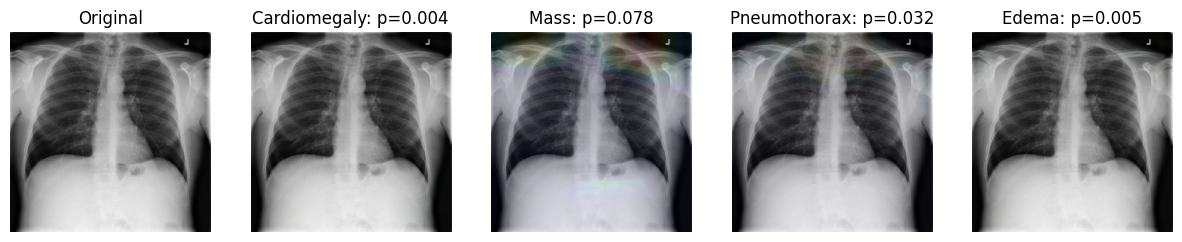

In [17]:
compute_gradcam(model, '00008270_015.png', IMAGE_DIR, df, labels, labels_to_show)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


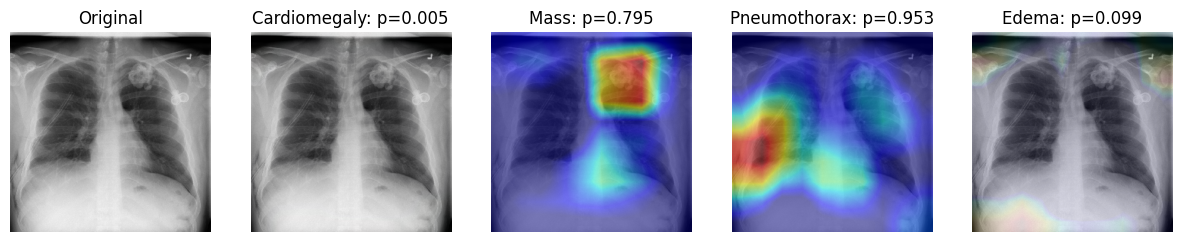

In [18]:
compute_gradcam(model, '00011355_002.png', IMAGE_DIR, df, labels, labels_to_show)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


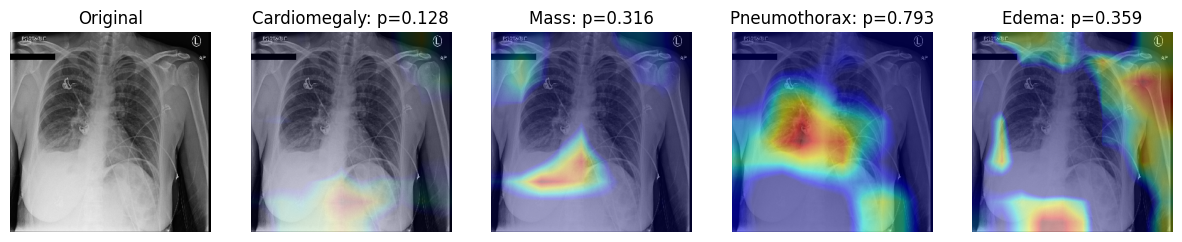

In [19]:
compute_gradcam(model, '00029855_001.png', IMAGE_DIR, df, labels, labels_to_show)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Mass
Generating gradcam for class Pneumothorax
Generating gradcam for class Edema


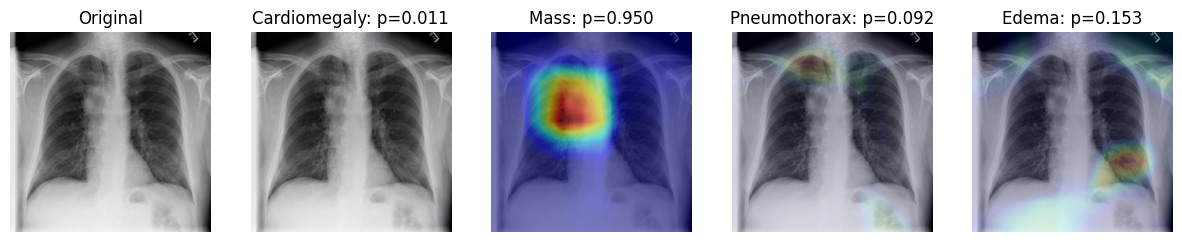

In [20]:
compute_gradcam(model, '00005410_000.png', IMAGE_DIR, df, labels, labels_to_show)

Parabéns! Você aprendeu a pré-processar dados, identificar vazamento de dados, treinar um modelo pré-treinado e avaliar usando AUC. Ótimo trabalho!

<a name='4'></a>
## 4 Treinamento

Com nosso modelo pronto para o treinamento, usaremos a função `model.fit()` do Keras para treinar o modelo.
- Estamos treinando em um pequeno subconjunto do conjunto de dados (~1%).
- Nosso objetivo, neste ponto, é garantir que a perda no conjunto de treinamento esteja diminuindo.

Como o treinamento pode demorar consideravelmente, optamos por não treinar o modelo aqui, mas sim carregar um conjunto de pesos pré-treinados na próxima seção. No entanto, você pode usar o código abaixo para praticar o treinamento do modelo localmente em sua máquina ou no Colab.

In [ ]:
history = model.fit(train_generator,
                               validation_data=valid_generator,
                               steps_per_epoch=100,
                               validation_steps=25,
                               epochs = 3)

plt.plot(history.history['loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
